In [2]:
import polars as pl

# 指定檔案路徑
csv_path = "C:/Users/Leon/Desktop/程式語言資料/python/TD-UF/Anti Money Laundering Transaction Data (SAML-D)/SAML-D.csv"

# 讀取資料（只讀前幾列即可）
df = pl.read_csv(csv_path, n_rows=5)

# 列出所有欄位名稱
print("📋 資料欄位如下：")
for i, col in enumerate(df.columns):
    print(f"{i + 1}: {col!r}")


📋 資料欄位如下：
1: 'Time'
2: 'Date'
3: 'Sender_account'
4: 'Receiver_account'
5: 'Amount'
6: 'Payment_currency'
7: 'Received_currency'
8: 'Sender_bank_location'
9: 'Receiver_bank_location'
10: 'Payment_type'
11: 'Is_laundering'
12: 'Laundering_type'


🔧 Label Encoding 中...


Encoding: 100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


🚀 訓練 XGBoost 模型中...


c:\Users\Leon\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ SHAP 圖已輸出為 shap_summary_plot.png，展示模型判斷洗錢的重要特徵


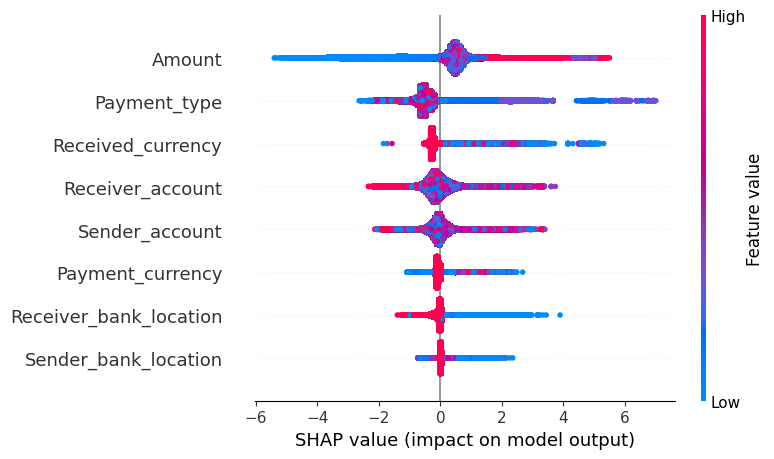

In [8]:
import polars as pl
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: 讀取資料
file_path = "C:/Users/Leon/Desktop/程式語言資料/python/TD-UF/Anti Money Laundering Transaction Data (SAML-D)/SAML-D.csv"
df = pl.read_csv(file_path)

# Step 2: 僅保留有意義的欄位
selected_columns = [
    "Sender_account", "Receiver_account", "Amount",
    "Payment_currency", "Received_currency",
    "Sender_bank_location", "Receiver_bank_location",
    "Payment_type", "Is_laundering"
]
df = df.select([col for col in selected_columns if col in df.columns])

# Step 3: 轉為 pandas 並進行 Label Encoding
df_pd = df.to_pandas()
encoders = {}

print("🔧 Label Encoding 中...")
for col in tqdm(df_pd.columns, desc="Encoding"):
    if df_pd[col].dtype == 'object':
        enc = LabelEncoder()
        df_pd[col] = enc.fit_transform(df_pd[col].astype(str))
        encoders[col] = enc

# Step 4: 建立訓練資料
X = df_pd.drop(columns=["Is_laundering"])
y = df_pd["Is_laundering"]

# Step 5: 使用全資料訓練模型（僅為了解釋特徵）
print("🚀 訓練 XGBoost 模型中...")
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

# Step 6: 計算 SHAP 值
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Step 7: SHAP summary plot 儲存圖片
plt.figure()
shap.summary_plot(shap_values, X, show=False)
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches="tight")

# Step 8: 輸出提示
print("✅ SHAP 圖已輸出為 shap_summary_plot.png，展示模型判斷洗錢的重要特徵")


🔄 讀取資料中...
🧱 構建 DAG（TD-Union-Find）中...


100%|██████████| 9504852/9504852 [00:38<00:00, 248365.66it/s]


🔃 執行 Kahn 抽順排序...
📈 計算 PoH 分數...


100%|██████████| 855460/855460 [00:01<00:00, 481461.92it/s] 


📊 計算評估指標...
+---------------------+---------+
| Metric              |   Value |
+=====================+=========+
| Total Nodes         |  855460 |
+---------------------+---------+
| Total Edges         |  839868 |
+---------------------+---------+
| Detected Risk Nodes |     153 |
+---------------------+---------+
| Threshold           |       5 |
+---------------------+---------+
| TP                  |       0 |
+---------------------+---------+
| FP                  |     153 |
+---------------------+---------+
| FN                  |    1264 |
+---------------------+---------+
| Precision           |       0 |
+---------------------+---------+
| Recall              |       0 |
+---------------------+---------+
| F1-score            |       0 |
+---------------------+---------+
🖼️ 產生高風險路徑圖...
✅ 已儲存圖檔：high_risk_path_weighted.png


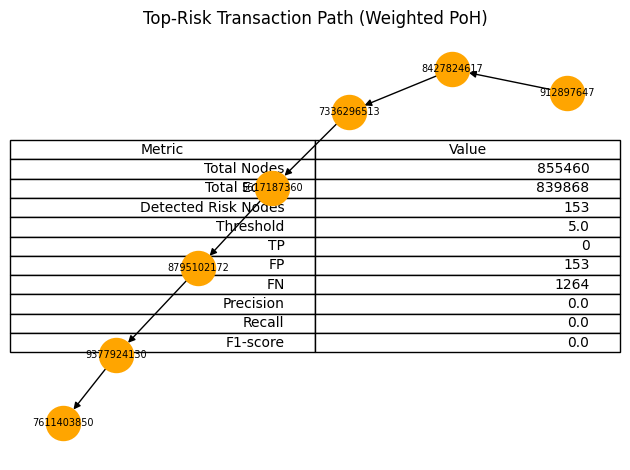

In [1]:
import polars as pl
import networkx as nx
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt

# === 高風險地區清單（示意） === #
high_risk_regions = {"Cayman Islands", "Seychelles", "Panama", "Belize"}

# === SHAP 權重邏輯（來自前面圖表） === #
def compute_risk_score(row):
    score = 0.0
    if row["Amount"] > 100000:
        score += 2.0
    if row["Payment_type"] in ["Wire Transfer", "Cash"]:
        score += 1.5
    if row["Received_currency"] in ["BTC", "ETH", "XMR"]:
        score += 1.2
    if row["Payment_currency"] in ["USD", "EUR"]:
        score += 0.5
    if row["Sender_bank_location"] in high_risk_regions:
        score += 0.8
    if row["Receiver_bank_location"] in high_risk_regions:
        score += 0.8
    return score

# === 載入資料 === #
print("🔄 讀取資料中...")
df = pl.read_csv("C:/Users/Leon/Desktop/程式語言資料/python/TD-UF/Anti Money Laundering Transaction Data (SAML-D)/SAML-D.csv")

df = df.with_columns([
    pl.concat_str(["Date", "Time"], separator=" ").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").alias("timestamp")
]).sort("timestamp")

# === 建立 DAG + TD-Union-Find === #
parent = {}
def find(u):
    if parent[u] != u:
        parent[u] = find(parent[u])
    return parent[u]
def union(u, v):
    pu, pv = find(u), find(v)
    if pu != pv:
        parent[pv] = pu

print("🧱 構建 DAG（TD-Union-Find）中...")
G = nx.DiGraph()
risk_edges = []

for row in tqdm(df.iter_rows(named=True), total=df.shape[0]):
    u, v = row["Sender_account"], row["Receiver_account"]
    if u not in parent: parent[u] = u
    if v not in parent: parent[v] = v
    if find(u) != find(v):
        score = compute_risk_score(row)
        G.add_edge(u, v, timestamp=str(row["timestamp"]), risk=score)
        union(u, v)
        risk_edges.append((u, v, score))

# === 抽順排序 === #
print("🔃 執行 Kahn 抽順排序...")
topo_order = list(nx.topological_sort(G))

# === PoH 累積風險計算 === #
print("📈 計算 PoH 分數...")
node_risk = {node: 0.0 for node in G.nodes}
for node in tqdm(topo_order, total=len(topo_order)):
    for pred in G.predecessors(node):
        edge_risk = G[pred][node]['risk']
        node_risk[node] = max(node_risk[node], node_risk[pred] + edge_risk)

# === 風險門準與驗證 === #
print("📊 計算評估指標...")
label_map = {row["Receiver_account"]: row["Is_laundering"] for row in df.iter_rows(named=True)}
threshold = 5.0
predicted_risks = [n for n, s in node_risk.items() if s >= threshold]

TP = sum(label_map.get(n) == 1 for n in predicted_risks)
FP = sum(label_map.get(n) == 0 for n in predicted_risks)
FN = sum(1 for k, v in label_map.items() if v == 1 and k not in predicted_risks)
precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)

# === 輸出統計結果 === #
metrics = [
    ["Total Nodes", G.number_of_nodes()],
    ["Total Edges", G.number_of_edges()],
    ["Detected Risk Nodes", len(predicted_risks)],
    ["Threshold", threshold],
    ["TP", TP], ["FP", FP], ["FN", FN],
    ["Precision", round(precision, 4)],
    ["Recall", round(recall, 4)],
    ["F1-score", round(f1, 4)],
]
print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))

# === 儲存圖表版本 === #
fig, ax = plt.subplots()
ax.axis('off')
table_plot = ax.table(cellText=metrics, colLabels=["Metric", "Value"], loc='center')
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(10)
plt.savefig("kahn_poh_td_uf_metrics.png", dpi=300, bbox_inches="tight")

# === 可視化高風險路徑 === #
print("🖼️ 產生高風險路徑圖...")
top_node = max(predicted_risks, key=lambda x: node_risk[x], default=None)
if top_node:
    path = []
    cur = top_node
    while True:
        preds = list(G.predecessors(cur))
        if not preds: break
        cur = max(preds, key=lambda p: node_risk[p])
        path.append(cur)
    path = list(reversed(path)) + [top_node]
    nx.draw(G.subgraph(path), with_labels=True, node_color='orange', node_size=600, font_size=7)
    plt.title("Top-Risk Transaction Path (Weighted PoH)")
    plt.tight_layout()
    plt.savefig("high_risk_path_weighted.png")
    print("✅ 已儲存圖檔：high_risk_path_weighted.png")
